Allison Forte

Assignemnt 8.2: (9.1; 10.1)

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

# 9.1
As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real. 

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame. 

What happens to the p-values of these tests as the sample size decreases? What is the smallest sample size that yeilds a positive test?

In [70]:
# import packages

import os
os.chdir('/Users/allison.forte/downloads/ThinkStats2-master 2/code')
import first
import nsfg
import numpy as np
import random
import thinkstats2
import thinkplot

# create data frames

live, firsts, others = first.MakeFrames()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [68]:
# Bring in tests defined in chapter

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

    
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
    
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [72]:
# Define how to run tests to validate chapter results, set to run tests for data frame 'live' and 1000 iterations

def RunTests(live, iters = 1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values  # selecting data for this test
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)  # dropping n/a values from the data
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters = iters)

    # test correlation
    live2 = live.dropna(subset = ['agepreg', 'totalwgt_lb'])  # selecting the subset of data
    data = live2.agepreg.values, live2.totalwgt_lb.values  # defining data for this test
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters = iters)

    # compare pregnancy lengths (chi-squared)  # data for this test is the same as the other test for comparing pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values  # selecting data for this test
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters = iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))


n = len(live)  # begins with sample size of length of data set 
for _ in range(7):  # runs the tests 7 times
    sample = thinkstats2.SampleRows(live, n)  # creates the sample for this run through
    RunTests(sample)  # runs the tests
    n //= 2  # redefines n from the length of the data frame to n divided by 2 rounded to a whole number

9148	0.14	0.00	0.00	0.00
4574	0.20	0.03	0.00	0.00
2287	0.15	0.76	0.00	0.00
1143	0.58	0.50	0.00	0.00
571	0.10	0.56	0.11	0.01
285	0.57	0.34	0.86	0.47
142	0.18	0.24	0.11	0.20


In [74]:
# The results of these tests show the difference in mean pregnancy test first followed by the difference in birth weight. 
# The 3rd test shows the correlation of mothers age and birth weight and the final test looks at pregnancy length again with a chi-squared test.

# n     1.      2.      3.      4. 
# 9148	0.14	0.00	0.00	0.00
# 4574	0.20	0.03	0.00	0.00
# 2287	0.15	0.76	0.00	0.00
# 1143	0.58	0.50	0.00	0.00
# 571	0.10	0.56	0.11	0.01
# 285	0.57	0.34	0.86	0.47
# 142	0.18	0.24	0.11	0.20

# We expect that as sample size decreases, tests are less likely to return a strong p-value. 
# Test 2, 3, and 4 all show a very strong p-value for large data sets but do not show such a 
# strong p-value as the sample size decreases.
# We can see the p-value for the difference in birth weights drops faster than the last 2 tests. 
# We want to run tests with a large sample size so we do not miss a true relationship between variables. 

# 10.1
Using data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone's weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without wieghts, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimate?

In [79]:
import brfss
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

data_frame = brfss.ReadBrfss(nrows=None)
data_frame = data_frame.dropna(subset=['htm3', 'wtkg2'])
heights, weights = data_frame.htm3, data_frame.wtkg2
log_weights = np.log10(weights)

Compute the linear least squares fit for log(weight) versus height

In [88]:
def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope
inter, slope = LeastSquares(heights, log_weights)
print('The intercept of the model is {} and the slope of the model is {}.'.format(inter, slope))

The intercept of the model is 0.993080416391812 and the slope of the model is 0.005281454169417809.


How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? 

Response: To best present the parameters for a model like this, we could show the data and line on a plot. We could plot the line aginst log_weights, or to make it easier to interpret, we could plot the line against weights (not log_weights). A plot against weight is shown below. 

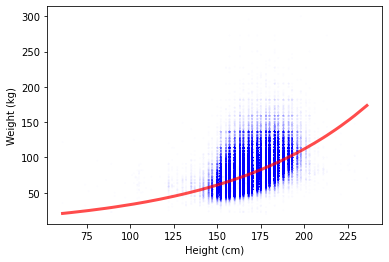

In [90]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

If you were trying to guess someone's weight, how much would it help to know their height?

Response: Knowing someones height can help significantly when guessing their weight. However, there is still a significant range for each height that you could expect someone to be in. Looking at the plot above, you can see from the blue lines that there is a significant range for each height but starting with the model will get you close. 

Use resampling, with and without wieghts, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval

In [98]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(data_frame)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

# standard error (or deviation) of the mean
stderr = thinkstats2.Std(slopes)
stderr


1.4547233076157436e-05

How much does correct weighting affect the estimate?

Correct weighting makes a significant difference on the estimate. Errors in weights in the data can significantly impact the model. We would need to check for outliers or missing data before creating a model to ensure it is as accurate as possible. 